# 1. Imports and Data

In [42]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import shapiro

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import keras_tuner as kt

# Load data (same pathing style as before)
data = pd.read_csv("data_for_train.csv")
data = data.drop('Unnamed: 0', axis=1)

data  # display

,id,date,screen,call,sms,mood,circumplex.arousal,circumplex.valence,activity,appCat.builtin,...,appCat.communication_normalized,appCat.entertainment_normalized,appCat.other_normalized,appCat.social_normalized,day_of_week_sin,day_of_week_cos,month_sin,month_cos,high_activity,mood_category
0,AS14.01,2014-03-30,0.233209,4.2,3.4,7.500000,-0.500000,0.75,0.110931,414.365,...,0.372039,0.439992,0.021203,0.048044,-0.781831,0.623490,1.000000,6.123234e-17,0,high
1,AS14.01,2014-03-31,0.610632,6.0,2.0,7.400000,0.000000,0.60,0.159315,2961.405,...,0.456868,0.150693,0.023008,0.115716,0.000000,1.000000,1.000000,6.123234e-17,0,high
2,AS14.01,2014-04-01,0.886055,1.0,1.6,6.000000,0.200000,0.00,0.267636,1385.517,...,0.445810,0.075378,0.008863,0.368616,0.781831,0.623490,0.866025,-5.000000e-01,0,low
3,AS14.01,2014-04-04,0.638632,2.0,1.0,6.200000,0.200000,0.40,0.286269,1957.829,...,0.487356,0.137382,0.015719,0.185478,-0.433884,-0.900969,0.866025,-5.000000e-01,0,low
4,AS14.01,2014-04-05,0.172171,2.0,3.2,6.800000,-0.400000,0.60,0.268900,15159.190,...,0.107337,0.004348,0.004619,0.020678,-0.974928,-0.222521,0.866025,-5.000000e-01,0,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,AS14.33,2014-05-11,0.275172,3.2,2.8,6.000000,0.000000,0.40,0.025225,259.893,...,0.094652,0.067092,0.010046,0.779455,-0.781831,0.623490,0.500000,-8.660254e-01,0,low
917,AS14.33,2014-05-12,0.800801,1.0,2.0,6.000000,-0.750000,0.50,0.054270,1196.532,...,0.150803,0.067181,0.041487,0.571242,0.000000,1.000000,0.500000,-8.660254e-01,0,low
918,AS14.33,2014-05-13,0.970030,1.0,2.0,5.000000,0.500000,0.00,0.316265,2505.530,...,0.379729,0.107784,0.003460,0.289844,0.781831,0.623490,0.500000,-8.660254e-01,0,low
919,AS14.33,2014-05-14,0.213907,1.6,3.0,6.833333,-0.333333,0.40,0.009006,268.980,...,0.029908,0.203304,0.018769,0.698016,0.974928,-0.222521,0.500000,-8.660254e-01,0,medium


# 2. mood_category (encode for LSTM)

In [20]:
label_encoder = LabelEncoder()
data['mood_category_encoded'] = label_encoder.fit_transform(data['mood_category'])
target = to_categorical(data['mood_category_encoded'])

# Identify numeric features (exclude the encoded target)
numeric_features = data.select_dtypes(include=[np.number]).columns.tolist()
if 'mood_category_encoded' in numeric_features:
    numeric_features.remove('mood_category_encoded')

# Normalize features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[numeric_features])
print("Classes:", list(label_encoder.classes_))
print("X shape:", scaled_features.shape, "| y shape:", target.shape)


Classes: ['high', 'low', 'medium']
X shape: (921, 48) | y shape: (921, 3)


# 3. Split dataset (chronological)

In [23]:
# First split: Train vs Remaining (70% / 30%) without shuffling
X_train, X_remaining, y_train, y_remaining = train_test_split(
    scaled_features, target, test_size=0.3, shuffle=False, random_state=42
)

# Second split: Validation vs Test (15% each overall)
X_val, X_test, y_val, y_test = train_test_split(
    X_remaining, y_remaining, test_size=0.5, shuffle=False, random_state=42
)

# Reshape for LSTM: (samples, timesteps=1, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val   = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test  = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

X_train.shape, X_val.shape, X_test.shape

((644, 1, 48), (138, 1, 48), (139, 1, 48))

# 4. Train LSTM (baseline)

In [34]:
model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # 3 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    epochs=500,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=False  # keep chronology
)

# Evaluate on test set
performance = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {performance[0]:.4f}, Test Accuracy: {performance[1]:.4f}")

Epoch 1/500
21/21 [==============================] - 3s 46ms/step - loss: 1.1067 - accuracy: 0.3447 - val_loss: 1.1241 - val_accuracy: 0.2174
Epoch 2/500
21/21 [==============================] - 0s 4ms/step - loss: 1.0807 - accuracy: 0.4130 - val_loss: 1.1584 - val_accuracy: 0.2174
Epoch 3/500
21/21 [==============================] - 0s 3ms/step - loss: 1.0700 - accuracy: 0.4161 - val_loss: 1.1673 - val_accuracy: 0.2174
Epoch 4/500
21/21 [==============================] - 0s 3ms/step - loss: 1.0639 - accuracy: 0.4224 - val_loss: 1.1545 - val_accuracy: 0.2174
Epoch 5/500
21/21 [==============================] - 0s 3ms/step - loss: 1.0482 - accuracy: 0.4519 - val_loss: 1.1369 - val_accuracy: 0.2319
Epoch 6/500
21/21 [==============================] - 0s 3ms/step - loss: 1.0390 - accuracy: 0.4674 - val_loss: 1.1315 - val_accuracy: 0.2609
Epoch 7/500
21/21 [==============================] - 0s 3ms/step - loss: 1.0115 - accuracy: 0.4876 - val_loss: 1.1101 - val_accuracy: 0.3188
Epoch 8/500


# 5. Hyperparamete Tuning

In [37]:
def build_model(hp):
    model = Sequential()
    # (Same logic as your notebook)
    for i in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(LSTM(
            units=hp.Int('lstm_units', min_value=32, max_value=256, step=32),
            input_shape=(X_train.shape[1], X_train.shape[2]),
            return_sequences=True if i < hp.Int('num_lstm_layers', 1, 3) - 1 else False,
            dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1),
        ))
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_dense', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(3, activation='softmax'))

    model.compile(
        optimizer=Adam(
            hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
        ),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='tune_lstm_mood_v2'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    shuffle=False,
    callbacks=[stop_early],
    verbose=2
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters found:")
for param, value in best_hps.values.items():
    print(f"{param}: {value}")

Trial 20 Complete [00h 00m 05s]
val_accuracy: 0.6376811861991882

Best val_accuracy So Far: 0.9347826242446899
Total elapsed time: 00h 02m 24s
Best hyperparameters found:
num_lstm_layers: 1
lstm_units: 96
dropout: 0.0
dense_units: 64
dropout_dense: 0.1
learning_rate: 0.0016187959221574872


# 6. Retrain with best & Plots

Epoch 1/100
21/21 [==============================] - 3s 23ms/step - loss: 1.1189 - accuracy: 0.3028 - val_loss: 1.1395 - val_accuracy: 0.2174
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 1.0807 - accuracy: 0.4208 - val_loss: 1.1686 - val_accuracy: 0.2174
Epoch 3/100
21/21 [==============================] - 0s 3ms/step - loss: 1.0623 - accuracy: 0.4270 - val_loss: 1.1378 - val_accuracy: 0.2246
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 1.0274 - accuracy: 0.4876 - val_loss: 1.0687 - val_accuracy: 0.4493
Epoch 5/100
21/21 [==============================] - 0s 3ms/step - loss: 0.9878 - accuracy: 0.5093 - val_loss: 0.9689 - val_accuracy: 0.5507
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 0.9395 - accuracy: 0.5217 - val_loss: 0.9081 - val_accuracy: 0.5652
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 0.9092 - accuracy: 0.5481 - val_loss: 0.9086 - val_accuracy: 0.5435
Epoch 8/100


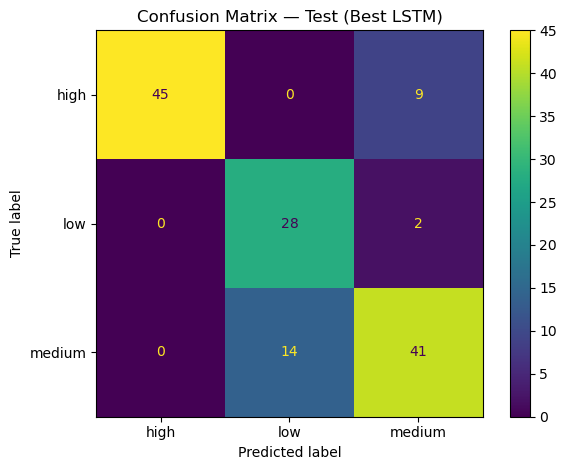

In [56]:
best_model = tuner.hypermodel.build(best_hps)

history = best_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    shuffle=False,
    # callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    verbose=1
)

# Test-set evaluation
test_loss, test_acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Final Test Loss: {test_loss:.4f}, Final Test Accuracy: {test_acc:.4f}")

# Test-set classification report
y_test_true = np.argmax(y_test, axis=1)
y_test_pred = np.argmax(best_model.predict(X_test, verbose=0), axis=1)

try:
    target_names = list(label_encoder.classes_)
except NameError:
    target_names = [f"class_{i}" for i in range(y_test.shape[1])]

print("Classification Report (Test):")
print(classification_report(y_test_true, y_test_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(values_format='d')
plt.title("Confusion Matrix — Test (Best LSTM)")
plt.tight_layout()
plt.show()

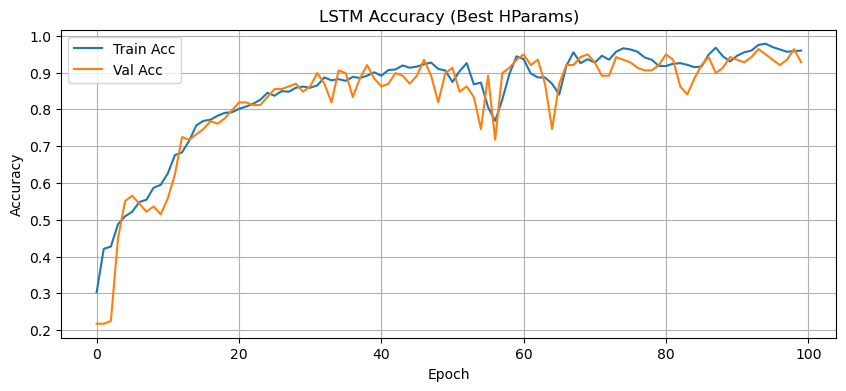

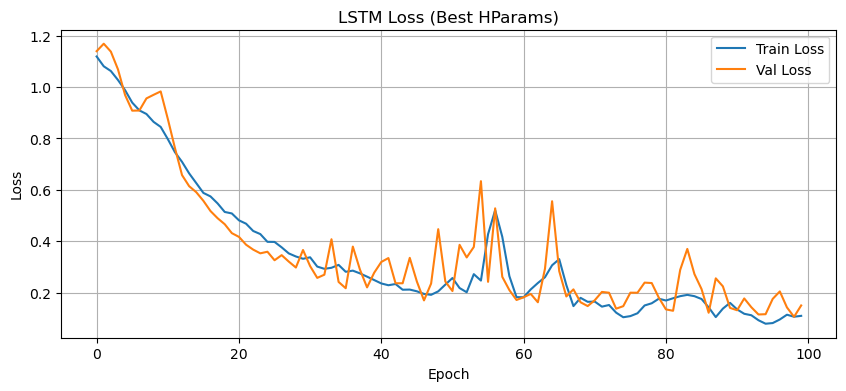

In [57]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('LSTM Accuracy (Best HParams)')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.grid(True); plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM Loss (Best HParams)')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.grid(True); plt.legend()
plt.show()